# Fatal Encounters. Justified?

## Problem

Using the [fatal encounters dataset](https://docs.google.com/spreadsheets/d/1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE/edit#gid=0),
create a classifier that takes as input text and other attributes and tries
to predict the target variable `Official disposition of death (justified or other)`.

## Questions

- What are the relevant socially sensitive (including `protected_class_attribute`)
  in the dataset?
- Does the data contain `potentially discriminatory` patterns? With respect
  to which definition of fairness?
- Which features are being chosen to predict the target?

# Get Data

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Markdown, display

sns.set_style("white")

%matplotlib inline

In [8]:
data = pd.read_csv("data/fatal_encounters_dataset.csv")
# clean data column names
data.columns = (
    data.columns
    .str.replace("'", "")
    .str.replace("[^a-zA-Z]", "_")
    .str.replace("_+", "_")
    .str.strip("_")
    .str.lower()
    .str.strip()
)
data = data[data.columns[~data.columns.str.startswith("unnamed")]]

In [9]:
def examine(df, n_sample=3):
    return (
        df.describe(include="all").T
        [["count", "unique", "mean", "std"]]
        .merge(
            df.apply(
                lambda s: s.sample(
                    n_sample, random_state=90).reset_index(drop=True))
                .T.rename(columns={
                    i: "sample_%s" % (i + 1) for i in range(n_sample)}),
            how="left", left_index=True, right_index=True))

examine(data, n_sample=2)

,count,unique,mean,std,sample_1,sample_2
comments,23428,NaN,11714.5,6763.23,620,11227
subjects_name,23429,22444,NaN,NaN,Richard Lawrence Holtz,Tamon Robinson
subjects_age,22716,122,NaN,NaN,45,27
subjects_gender,23365,4,NaN,NaN,Male,Male
subjects_race,23428,7,NaN,NaN,African-American/Black,African-American/Black
url_of_image_of_deceased,8133,8054,NaN,NaN,NaN,http://i.huffpost.com/gen/584683/thumbs/o-TAMO...
date_of_injury_resulting_in_death_month_day_year,23429,6254,NaN,NaN,12/07/2000,04/12/2012
location_of_injury_address,22910,21502,NaN,NaN,399 Monmouth St.,Seaview Avenue and E. 102nd St.
location_of_death_city,23391,5311,NaN,NaN,East Windsor,Brooklyn
location_of_death_state,23428,51,NaN,NaN,NJ,NY


# Exploration

In [10]:
# TARGET VARIABLE
JUSTIFIED = "official_disposition_of_death_justified_or_other"

# Features of interest
SENSITIVE_ATTRIBUTES = [
    "subjects_name",
    "subjects_age",
    "subjects_gender",
    "subjects_race",
    "url_of_image_of_deceased",
    "symptoms_of_mental_illness"
]

FEATURES = [
    "agency_responsible_for_death",
    "cause_of_death",
    "a_brief_description_of_the_circumstances_surrounding_the_death",
    "location_of_death_city",
    "location_of_death_state",
    "location_of_death_zip_code",
    "location_of_death_county",
]

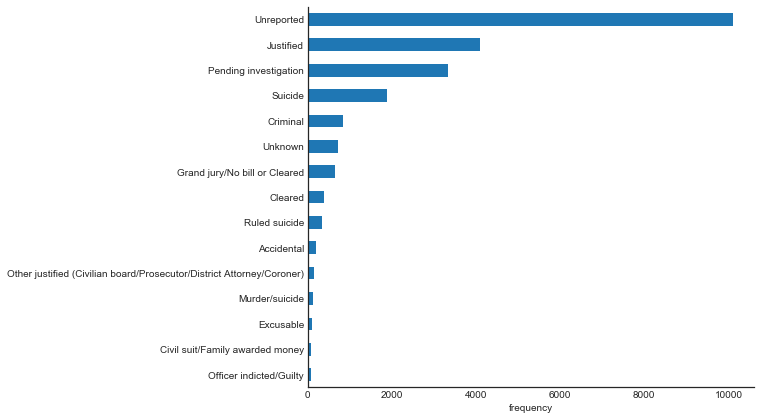

In [11]:
def plot_categorical(s, top_n=15, **kwargs):
    ax = s.value_counts().sort_values().tail(top_n).plot.barh(**kwargs)
    ax.set_xlabel("frequency");
    sns.despine()
    return ax


plot_categorical(data[JUSTIFIED], figsize=(8, 7));

# Preprocess

encode target variable into buckets: `justified`, `other`, and
`unknown`. For modeling throw `unknown` data out for the first pass.

## Target Variable

In [12]:
JUSTIFIED_STRINGS = [
    "Justified",
    "Justifed",
    "Jusified",
    "Justified by internal review",
    "Justified by outside agency",
    "Justified by District Attorney",
    "Other justified (Civilian board/Prosecutor/District Attorney/Coroner)"
]
UNKNOWN_STRINGS = [
    "Unreported",
    "Unknown",
]

RACE = "subjects_race"
GENDER = "subjects_gender"


def encode_target(s):
    if pd.isnull(s):
        return "UNKNOWN"
    s = s.strip()
    if s in JUSTIFIED_STRINGS:
        return "JUSTIFIED"
    elif s in UNKNOWN_STRINGS:
        return "UNKNOWN"
    else:
        return "OTHER"

gender_encoding_map = {
    "Female": "FEMALE",
    "Femalr": "FEMALE",
    "Transgender": "TRANSGENDER",
    "Male": "MALE",
}
race_encoding_map = {
    "Race unspecified": "RACE_UNSPECIFIED",
    "European-American/White": "WHITE",
    "African-American/Black": "BLACK",
    "Hispanic/Latino": "LATINO",
    "Asian/Pacific Islander": "ASIAN_PACIFIC_ISLANDER",
    "Native American/Alaskan": "NATIVE_AMERICAN_ALASKAN",
    "Middle Eastern": "MIDDLE_EASTERN",
}

clean_data = data.copy()
clean_data[JUSTIFIED] = data[JUSTIFIED].map(encode_target)
clean_data[JUSTIFIED].value_counts().to_frame()
clean_data[GENDER] = data[GENDER].map(gender_encoding_map)
clean_data[RACE] = data[RACE].map(race_encoding_map)

# exclude records with "UNKNOWN" disposition and "UNSPECIFIED RACE"
clean_data = clean_data[clean_data[JUSTIFIED] != "UNKNOWN"]
clean_data = clean_data[clean_data[RACE] != "RACE_UNSPECIFIED"]

clean_data[JUSTIFIED].value_counts().to_frame()

,official_disposition_of_death_justified_or_other
OTHER,5986
JUSTIFIED,2957


## Sensitive Attributes: Gender and Race

In [13]:
clean_data.subjects_gender.value_counts().to_frame()

,subjects_gender
MALE,8120
FEMALE,806
TRANSGENDER,6


In [14]:
clean_data.subjects_race.value_counts().to_frame()

,subjects_race
WHITE,4433
BLACK,2616
LATINO,1550
ASIAN_PACIFIC_ISLANDER,179
NATIVE_AMERICAN_ALASKAN,136
MIDDLE_EASTERN,29


## Features

In [15]:
examine(clean_data[FEATURES])

,count,unique,mean,std,sample_1,sample_2,sample_3
agency_responsible_for_death,8933,3417,NaN,NaN,Davenport Police Department,Madison Police Department.,Corona Police Department
cause_of_death,8943,14,NaN,NaN,Vehicle,Gunshot,Gunshot
a_brief_description_of_the_circumstances_surrounding_the_death,8943,8642,NaN,NaN,"Just after 7 a.m., police began following a Je...",Charles Carll was armed with a knife and repor...,A man was shot and killed by a Corona police o...
location_of_death_city,8933,3021,NaN,NaN,Davenport,Madison,Norco
location_of_death_state,8943,51,NaN,NaN,IA,WI,CA
location_of_death_zip_code,8897,NaN,59714.8,27746,52802,53711,92880
location_of_death_county,8935,1106,NaN,NaN,Scott,Dane,Riverside


In [16]:
clean_data.cause_of_death.value_counts().to_frame()

,cause_of_death
Gunshot,7534
Vehicle,758
Tasered,266
Asphyxiated/Restrained,99
Beaten/Bludgeoned with instrument,71
Medical emergency,70
Other,35
Drug overdose,32
Drowned,16
Stabbed,16


TODO: tokenize `a_brief_description_of_the_circumstances_surrounding_the_death`
so that text is represented as a word vector.

# Assess Potentially Discriminatory (PD) Patterns

Get `mean_difference` score for the following sensitive attributes:
- subjects_gender
- subjects_race

In [17]:
from themis_ml.metrics import mean_difference, mean_confidence_interval

    
def report_mean_difference(y, s_list):
    report = []
    index = []
    for s_name, s in s_list:
        s_notnull = s.notnull()
        report.append(
            map(lambda x: x * 100, mean_difference(y[s_notnull], s[s_notnull])))
        index.append("{s_name} vs. NOT {s_name}".format(s_name=s_name))
    return pd.DataFrame(
        report, columns=["mean difference", "lower bound", "upper bound"],
        index=index)


is_justified = clean_data[JUSTIFIED] == "JUSTIFIED"
gender_vectors = [
    (g, (clean_data.subjects_gender == g).astype(int))
    for g in clean_data.subjects_gender.dropna().unique()]
gender_report = report_mean_difference(is_justified, gender_vectors)
gender_report

,mean difference,lower bound,upper bound
MALE vs. NOT MALE,-13.666524,-17.028157,-10.304891
FEMALE vs. NOT FEMALE,13.159141,9.764708,16.553574
TRANSGENDER vs. NOT TRANSGENDER,33.087166,-4.569341,70.743672


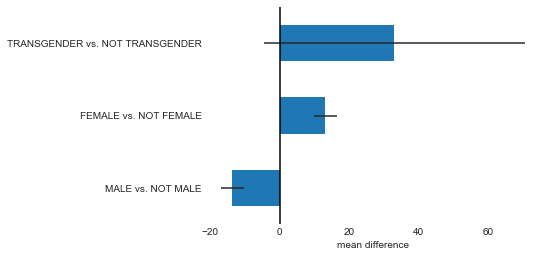

In [18]:
def plot_report(report):
    margin = (report["mean difference"] - report["lower bound"]).abs()
    ax = report[["mean difference"]].plot(
        kind="barh", xerr=margin, legend=False)
    ax.axvline(0, color="k")
    ax.set_xlabel("mean difference")
    sns.despine(bottom=True, left=True)
    
plot_report(gender_report)

If `mean difference` is negative with respect to some sensitive attribute value
$s \in \{d, a\}$ and some outcome $y \in \{y^{+}, y^{-}\}$ , it implies that
the members of the putatively disadvantaged class $d$ experiences the
beneficial outcome $y^{+}$ more often compared to the advantaged class $a$.

Conversely, if `mean difference` is positive with respect to some sensitive
attribute value $s \in \{d, a\}$ and some outcome $y \in \{y^{+}, y^{-}\}$ ,
it implies that members the putatively disadvantaged class $d$ experiences
the harmful outcome $y^{-}$ more often compared to the advantaged class $a$.

Interestingly, `MALE`s experience `JUSTIFIED` fatal encounters more than
their `NON MALE` counterparts

In [19]:
race_vectors = [
    (r, (clean_data.subjects_race == r).astype(int))
    for r in clean_data.subjects_race.dropna().unique()]
race_report = report_mean_difference(is_justified, race_vectors)
race_report

,mean difference,lower bound,upper bound
BLACK vs. NOT BLACK,-6.755053,-8.894059,-4.616047
WHITE vs. NOT WHITE,3.434001,1.484907,5.383095
NATIVE_AMERICAN_ALASKAN vs. NOT NATIVE_AMERICAN_ALASKAN,3.709616,-4.258527,11.677759
ASIAN_PACIFIC_ISLANDER vs. NOT ASIAN_PACIFIC_ISLANDER,0.106199,-6.856564,7.068962
LATINO vs. NOT LATINO,3.239307,0.663956,5.814657
MIDDLE_EASTERN vs. NOT MIDDLE_EASTERN,5.496584,-11.655494,22.648663


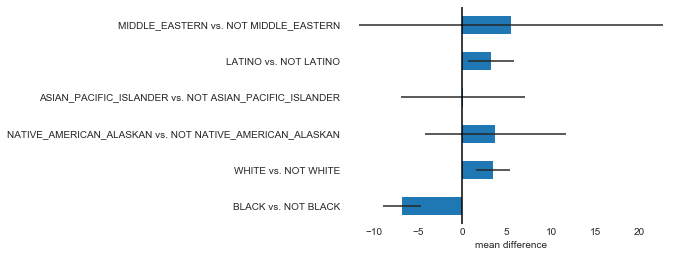

In [20]:
plot_report(race_report)

In [21]:
mental_illness_vectors = [
    (r, (clean_data.symptoms_of_mental_illness == r).astype(int))
    for r in clean_data.symptoms_of_mental_illness.dropna().unique()]
mental_illness_report = report_mean_difference(
    is_justified, mental_illness_vectors)
mental_illness_report

,mean difference,lower bound,upper bound
Unknown vs. NOT Unknown,2.123112,-0.552404,4.798628
Drug or alcohol use vs. NOT Drug or alcohol use,-8.490975,-12.735800,-4.246151
No vs. NOT No,6.085401,4.053744,8.117058
Yes vs. NOT Yes,-10.050927,-12.851683,-7.250171


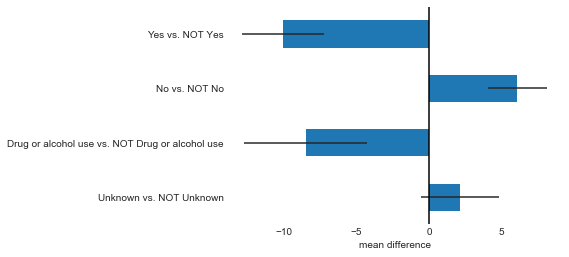

In [22]:
plot_report(mental_illness_report)

Interestingly, `MALE` and `BLACK` people experience `JUSTIFIED` fatal encounters more than
their `NON MALE` and `NON BLACK` counterparts, respectively.

This leads me to suspect that the labels `official_disposition_of_death_justified_or_other`
are somehow skewed against these two sensitive attribute value.

**WHO LABELLED THESE RECORDS?**

# Train Models

Train a logistic regression model to predict `JUSTIFIED = 1`, `OTHER = 0`.

In [23]:
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from themis_ml.linear_model import LinearACFClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score)

In [24]:
FAIRNESS_UNAWARE_FEATURES = [
    ("subjects_age", "NUMERIC"),
    ("subjects_gender", "CATEGORICAL"),
    ("subjects_race", "CATEGORICAL"),
    ("symptoms_of_mental_illness", "CATEGORICAL"),
    ("agency_responsible_for_death", "CATEGORICAL"),
    ("cause_of_death", "CATEGORICAL"),
    ("location_of_death_city", "CATEGORICAL"),
    ("location_of_death_state", "CATEGORICAL"),
    ("location_of_death_zip_code", "CATEGORICAL"),
    ("location_of_death_county", "CATEGORICAL"),
]


training_data = []
for feature, dtype in FAIRNESS_UNAWARE_FEATURES:
    if dtype == "NUMERIC":
        f = clean_data[feature].str.replace("[^0-9]", "").astype(float)
        training_data.append(f.where(f.notnull(), f.mean()))
    elif dtype == "CATEGORICAL":
        training_data.append(pd.get_dummies(clean_data[[feature]].fillna("NULL")))
training_data = pd.concat(training_data, axis=1)
features = training_data.columns
training_data = training_data.assign(
    target=(clean_data[JUSTIFIED] == "JUSTIFIED").astype(int))
assert training_data.notnull().all().all()
training_data.head()

,subjects_age,subjects_gender_FEMALE,subjects_gender_MALE,subjects_gender_NULL,subjects_gender_TRANSGENDER,subjects_race_ASIAN_PACIFIC_ISLANDER,subjects_race_BLACK,subjects_race_LATINO,subjects_race_MIDDLE_EASTERN,subjects_race_NATIVE_AMERICAN_ALASKAN,...,location_of_death_county_Yalobusha,location_of_death_county_Yamhill,location_of_death_county_Yavapai,location_of_death_county_Yellowstone,location_of_death_county_Yolo,location_of_death_county_York,location_of_death_county_Yuba,location_of_death_county_Yuma,location_of_death_county_kings,target
4,45.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,20.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,19.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15,35.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,36.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10)
estimators = [
    ("logistic_regression", LogisticRegression()),
    ("linear_acf", LinearACFClassifier()),
]
X = training_data[features].values
y = training_data["target"].values
s = training_data["subjects_race_BLACK"].values
strata = training_data["target"].astype(int).astype(str).str.cat(
    training_data["subjects_race_BLACK"].astype(int).astype(str), sep="_")
preds = []
for i, (train, test) in enumerate(cv.split(X, strata, groups=strata)):
    print("."),
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    s_train, s_test = s[train], s[test]
    for est_name, estimator in estimators:
        fit_args = (X_train, y_train, s_train) if est_name == "linear_acf" \
            else (X_train, y_train)
        predict_args = (X_test, s_test) if est_name == "linear_acf" \
            else (X_test, )
        estimator.fit(*fit_args)
        preds.append(
            pd.DataFrame({
                "pred_y": estimator.predict_proba(*predict_args)[:, 1],
                "pred_label": estimator.predict(*predict_args).astype(int),
                "true_y": y_test.astype(int),
                "sensitive_attribute": s_test,
                "rep_fold": i,
                "estimator": est_name,
            }))
preds = pd.concat(preds)

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


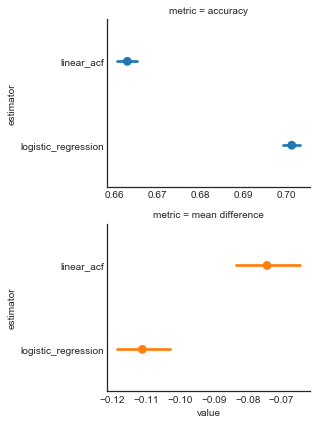

In [76]:
def compute_metrics(df):
    accuracy = accuracy_score(df.true_y, df.pred_label)
    mean_diff, lower, upper = mean_difference(df.pred_label, df.sensitive_attribute)
    return pd.Series({
        "accuracy": accuracy,
        "mean difference": mean_diff,
    })

metrics = (
    preds
    .groupby(["estimator", "rep_fold"])
    .apply(compute_metrics)
    .reset_index(0)
    .pipe(pd.melt, id_vars="estimator", var_name="metric",
          value_name="value")
)
sns.factorplot(
    x="value", y="estimator",
    hue="metric",
    row="metric",
    sharex=False,
    data=metrics,
    size=3, aspect=1.5,
    join=False);

In [79]:
(
    metrics
    .groupby(["metric", "estimator"])
    .agg([np.mean, np.std]))

value          
                                         mean       std
metric          estimator                              
accuracy        linear_acf           0.663043  0.006527
                logistic_regression  0.701297  0.005744
mean difference linear_acf          -0.074298  0.025480
                logistic_regression -0.111183  0.022025